In [1]:
import simplejson
import os
import numpy as np
import pandas as pd
import skimage.io
import skimage.filters.rank
import skimage.morphology
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Scene:
    def __init__(self, config):
        if type(config) == str:
            with open(config) as f:
                config = simplejson.load(f)
        self.config = config

    def normalize_img(self, index, channel, norm_type='none', path='solp', radius=0):
        img = self.read_image(index, channel, path)
        mask = self.read_image(index, 'mask', path)
        
        # TDB: fix radius support
        if radius > 0:
            if img.dtype != 'uint8':
                img = (img / 64).astype(np.uint16)
            img = skimage.filters.rank.median(img, skimage.morphology.disk(radius), mask=mask)
            if img.dtype != 'uint8':
                img = (img * 64).astype(np.uint16)
            # mask = skimage.filters.rank.median(img, skimage.morphology.disk(15))
            
        if norm_type == 'none':
            subtrahend = 0
            divider = 1 if img.dtype == 'uint8' else 256
        elif norm_type == 'disp':
            subtrahend = img[mask == 255].mean()
            divider = img[mask == 255].std()
        elif norm_type == 'refl':
            rad_refl = self.load_rad_refl()
            subtrahend = rad_refl['rad_' + channel][index]
            divider = rad_refl['refl_' + channel][index]
        elif norm_type == 'reflshiftshrink12':
            rad_refl = self.load_rad_refl()
            subtrahend = img[mask == 255].mean()
            if channel == 'red':
                divider = rad_refl['refl_red'][index]
            elif channel == 'nir':
                divider = rad_refl['refl_nir'][index] * np.tan(np.radians(45 + 12))
            else:
                raise ValueError('Unknown channel for norm type')
        elif norm_type == 'reflshiftE':
            rad_refl = self.load_rad_refl()
            if channel == 'red':
                e1 = rad_refl['refl_red'][index]
                e2 = rad_refl['refl_nir'][index] * np.tan(np.radians(45 + 12))
                k1 = img[mask == 255].mean() - rad_refl['rad_red'][index]
                k2 = self.read_image(index, 'nir', path)[mask == 255].mean() - rad_refl['rad_nir'][index]
                subtrahend = rad_refl['rad_red'][index] + (k1 / e1 - k2 / e2) / 2 * e1
                divider = rad_refl['refl_red'][index]
            elif channel == 'nir':
                e1 = rad_refl['refl_red'][index]
                e2 = rad_refl['refl_nir'][index] * np.tan(np.radians(45 + 12))
                k1 = self.read_image(index, 'red', path)[mask == 255].mean() - rad_refl['rad_red'][index]
                k2 = img[mask == 255].mean() - rad_refl['rad_nir'][index]
                subtrahend = rad_refl['rad_nir'][index] - (k1 / e1 - k2 / e2) / 2 * e2
                divider = rad_refl['refl_nir'][index] * np.tan(np.radians(45 + 12))
            else:
                raise ValueError('Unknown channel for norm type')
        else:
            raise ValueError('Unknown norm type')
            
        return (img.astype(np.float) - subtrahend) / divider

    def read_image(self, index, channel, path):
        return skimage.io.imread(os.path.join(self.config['path'], self.config['paths'][path], channel,
                                              self.config['scenes'][index]['path'] + self.config['suffs'][path]))

    def calculate_soil_line(self, img_red, img_nir, mask=None):
        if mask is None:
            x = img_red.reshape((-1,))
            y = img_nir.reshape((-1,))
        else:
            x = img_red[mask == 255]
            y = img_nir[mask == 255]
        return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]
    
    def make_channel_time_array(self, channel, norm_type='none', path='solp', radius=1):
        n_imgs = len(self.config['scenes'])
        width = self.config['size']['width']
        height = self.config['size']['height']
        
        if channel == 'mask':
            dtype = np.uint8
        else:
            dtype = np.float
        
        arr = np.empty((height, width, n_imgs), dtype=dtype)
        for i in range(n_imgs):
            if channel == 'mask':
                arr[:, :, i] = self.read_image(i, channel, path)
            else:
                arr[:, :, i] = self.normalize_img(i, channel, norm_type, path, radius)
        return arr
    
    def calculate_features(self):
        time_arrays = {}
        for channel in self.config['features']['use_channels'] + ['mask']:
            time_arrays[channel] = self.make_channel_time_array(channel, 
                                                                self.config['features']['norm_type'],
                                                                path = self.config['features']['path'],
                                                                radius = self.config['features']['radius'])
        for channel in self.config['features']['use_channels']:
            time_arrays[channel][time_arrays['mask'] == 0] = np.nan
        n_nonzero = np.count_nonzero(time_arrays['mask'], axis=2)
        
        res = []
        for f in self.config['features']['features']:
            if f['name'] == 'mean':
                res.append(np.nanmean(time_arrays[f['channel']], axis=2))
            elif f['name'] == 'min':
                res.append(np.nanmin(time_arrays[f['channel']], axis=2))
            elif f['name'] == 'max':
                res.append(np.nanmax(time_arrays[f['channel']], axis=2))
            elif f['name'] == 'std':
                res.append(np.nanstd(time_arrays[f['channel']], axis=2))
            elif f['name'] == 'soil_line_a':
                red_mean = np.nanmean(time_arrays['red'], axis=2)
                nir_mean = np.nanmean(time_arrays['nir'], axis=2)
                red_var = np.nanvar(time_arrays['red'], axis=2)
                red_nir_mult = np.nanmean(time_arrays['red'] * time_arrays['nir'], axis=2)
                res.append((red_nir_mult - red_mean * nir_mean) / red_var)
            elif f['name'] == 'n_nonzero':
                res.append(n_nonzero)
            else:
                raise ValueError('Unknown feature name')
        res = np.transpose(np.array(res), [1, 2, 0])
        res[n_nonzero < self.config['features']['n_nonzero_limit']] = np.nan
        return res
    
    def get_feature_names(self):
        feature_names = []
        for f in self.config['features']['features']:
            name = f['name']
            if 'channel' in f.keys():
                name += '_' + f['channel']
            feature_names.append(name)
        return feature_names
    
    def load_rad_refl(self):
        return pd.read_csv(os.path.join(self.config['path'], self.config['paths']['docs'],
                                        self.config['docs']['rad_refl']))
    
    def load_soil_cuts(self):
        cuts = pd.read_csv(os.path.join(self.config['path'], self.config['paths']['docs'], 
                                        self.config['docs']['cuts']))[['col', 'row', 'class']].values
        res = np.zeros(A.get_shape(), dtype=np.uint8)
        res[cuts[:, 1], cuts[:, 0]] = cuts[:, 2]
        return res
    
    def load_soil_map(self):
        return skimage.io.imread(os.path.join(self.config['path'], self.config['paths']['docs'], 
                                              self.config['docs']['soil_map']))
    
    def load_gran_map(self):
        return skimage.io.imread(os.path.join(self.config['path'], self.config['paths']['docs'], 
                                              self.config['docs']['gran_map']))
    
    def get_shape(self):
        return (self.config['size']['height'], self.config['size']['width'])

In [3]:
import xgboost
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

class Classifier:
    def __init__(self, features, targets, config):
        if type(config) == str:
            with open(config) as f:
                config = simplejson.load(f)
        self._config = config
        self.config = config['classifier']
        self.features = features
        self.targets = targets
        
        self.generate_train_mask()
        self.train_test_all_split()
        self.set_classifier()

    def generate_train_mask(self):
        if self.config['train_mask']['mode'] == 'horizontal':
            self.train_mask = np.zeros(self.targets.shape, dtype=np.bool)
            params = self.config['train_mask']['params']
            size_n = params['size_numerator']
            size_d = params['size_denominator']
            if size_n == 1:
                size = size_n / size_d
            elif size_d - size_n == 1:
                size = 1 - size_n / size_d
            else:
                raise ValueError('Invalid size options')
            begin = int(params['i'] * size * self.targets.shape[0])
            end = int((params['i'] + 1) * size * self.targets.shape[0])
            self.train_mask[begin:end, :] = True
            if size_n != 1:
                self.train_mask = np.logical_not(self.train_mask)
        elif self.config['train_mask']['mode'] == 'squares':
            self.train_mask = np.zeros(self.targets.shape, dtype=np.bool)
            params = self.config['train_mask']['params']
            square_size = params['square_size']
            shape = self.features.shape
            n = (shape[0] // square_size + 1) * (shape[1] // square_size + 1)
            size_n = params['size_numerator']
            size_d = params['size_denominator']
            if size_n == 1:
                size = size_n / size_d
            elif size_d - size_n == 1:
                size = 1 - size_n / size_d
            else:
                raise ValueError('Invalid size options')
            begin = int(params['i'] * size * n)
            end = int((params['i'] + 1) * size * n)
            arr = np.arange(n)
            np.random.seed(params['random_seed'])
            np.random.shuffle(arr)
            for i in arr[begin:end]:
                x_min = i % (shape[1] // square_size + 1) * square_size
                x_max = (i % (shape[1] // square_size + 1) + 1) * square_size
                y_min = i // (shape[1] // square_size + 1) * square_size
                y_max = (i // (shape[1] // square_size + 1) + 1) * square_size
                self.train_mask[y_min:y_max, x_min:x_max] = True
            if size_n != 1:
                self.train_mask = np.logical_not(self.train_mask)
        elif self.config['train_mask']['mode'] == 'none':
            self.train_mask = np.ones(self.targets.shape, dtype=np.bool)
        else:
            raise ValueError('Unknown train mask mode')
    
    def save_train_mask(self):
        skimage.io.imsave(os.path.join(self.config['output_path'], 'train_mask.png'), 
                          self.train_mask.astype(np.uint8) * 255)
        
    def save_map(self):
        if self.config['name'] == 'xgboost':
            y_pred = self.clf.predict(xgboost.DMatrix(self.x_all)).astype(np.int)
        else:
            y_pred = self.clf.predict(self.x_all).astype(np.int)
        y_pred[np.isnan(self.x_all).any(axis=1)] = 0
        skimage.io.imsave(os.path.join(self.config['output_path'], 'map.png'),
                                       y_pred.reshape(self.targets.shape))
        
    def save_class_maps(self):
        if self.config['name'] == 'xgboost':
            y_pred_cl = np.exp(self.clf.predict(xgboost.DMatrix(self.x_all), output_margin=True))
        else:
            y_red_cl = self.clf.predict_proba(self.x_all)
        y_pred_cl /= np.sum(y_pred_cl, axis=1, keepdims=True)
        for i in range(1, y_pred_cl.shape[1]):
            y_pred = (y_pred_cl[:, i] * 255).astype(np.uint8)
            y_pred[np.isnan(self.x_all).any(axis=1)] = 0
            skimage.io.imsave(os.path.join(self.config['output_path'], 'class_map_' + str(i) + '.png'), 
                              y_pred.reshape(self.targets.shape))
    
    def normalize_features(self, x):
        if x is not None:
            return (x - np.nanmean(x, axis=0, keepdims=True)) / np.nanstd(x, axis=0, keepdims=True)
        else:
            return None
    
    def train_test_all_split(self):        
        self.x_all = self.features.reshape((-1, self.features.shape[2]))
        self.y_all = self.targets.reshape((-1,))

        xy = np.concatenate([self.features, self.targets.reshape(self.targets.shape + (1,))], axis=2)
        xy[xy[:, :, -1] < 1] = np.nan

        for t in ['train', 'test']:
            if t == 'train':
                xy_tmp = np.copy(xy[self.train_mask > 0])
                size = self.config['train_size']
            else:
                xy_tmp = np.copy(xy[self.train_mask <= 0])
                size = self.config['test_size']
            if size <= 0:
                x_tmp, y_tmp = None, None
            else:
                xy_tmp = xy_tmp[~np.isnan(xy_tmp).any(axis=1)]
                xy_tmp = xy_tmp[np.random.choice(xy_tmp.shape[0], min(size, xy_tmp.shape[0]), replace=False)]
                x_tmp = xy_tmp[:, :-1]
                y_tmp = xy_tmp[:, -1].astype(np.int)
            if t == 'train':
                self.x_train = np.copy(x_tmp) if x_tmp is not None else None
                self.y_train = np.copy(y_tmp) if y_tmp is not None else None
            else:
                self.x_test = np.copy(x_tmp) if x_tmp is not None else None
                self.y_test = np.copy(y_tmp) if y_tmp is not None else None
        del xy_tmp, x_tmp, y_tmp
        
        if self.config['feature_normalization']:
            self.x_all = self.normalize_features(self.x_all)
            self.x_train = self.normalize_features(self.x_train)
            self.x_test = self.normalize_features(self.x_test)
    
    def set_classifier(self):
        if self.config['name'] == 'xgboost':
            self.clf = xgboost.Booster()
        elif self.config['name'] in ['rfc', 'svm', 'gnb', 'knn', 'lr']:
            if self.config['name'] == 'rfc':
                self.clf = RFC
            elif self.config['name'] == 'svm':
                self.clf = SVC
            elif self.config['name'] == 'gnb':
                self.clf = GNB
            elif self.config['name'] == 'knn':
                self.clf = KNN
            elif self.config['name'] == 'lr':
                self.clf = LR
            params = self.config['params'][self.config['name']]['params']
            self.clf = self.clf(**params)
        else:
            raise ValueError('Unknown classifier name')
            
    def set_grid_search_params(self):
        best_params = GridSearchCV(self.clf, self.config['gs_params'], 
                                   cv=self.config['cv'], n_jobs=2).fit(self.x_train, self.y_train).best_params_
        print('best params:', best_params)
        self.clf.set_params(**best_params)
            
    def train(self):
        if self.config['name'] == 'xgboost':
            self.clf = xgboost.train(self.config['params']['xgboost']['params'], 
                                     xgboost.DMatrix(self.x_train, label=self.y_train), 
                                     num_boost_round=self.config['params']['xgboost']['num_boost_round'])
        elif self.config['name'] in ['rfc', 'svm', 'gnb', 'knn', 'lr']:
            self.clf = self.clf.fit(self.x_train, self.y_train)
        else:
            raise ValueError('Unknown classifier name')
    
    def get_feature_importances(self, feature_names=None):
        if self.config['name'] == 'xgboost':
            if feature_names is None:
                mapped = self.clf.get_fscore()
            else:
                mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
                mapped = {mapper[k]: v for k, v in C.clf.get_fscore().items()}
            xgboost.plot_importance(mapped, xlabel=None, ylabel=None)
        else:
            raise ValueError('Unknown classifier name')
            
    def get_train_score(self):
        return self.get_score(mode='train')
        
    def get_test_score(self):
        return self.get_score(mode='test')
        
    def get_score(self, mode):
        if mode == 'train':
            x = self.x_train
            y = self.y_train
        elif mode == 'test':
            x = self.x_test
            y = self.y_test
        else:
            raise ValueError('Unknown mode')
        
        if x is None or x.size == 0:
                raise ValueError('x is None')
            
        if self.config['name'] == 'xgboost':
            x = xgboost.DMatrix(x)
        if self.config['scorer_name'] == 'accuracy':
            scorer = accuracy_score
        else:
            raise ValueError('Unknown scorer name')
        return scorer(y, self.clf.predict(x).astype(np.int))
    
    def get_cv_score(self):
        if self.config['name'] == 'xgboost':
            if self.config['scorer_name'] in ['accuracy', 'merror']:
                metrics = {'merror'}
            else:
                raise ValueError('Unknown scorer for xgboost')
            df = xgboost.cv(self.config['params']['xgboost']['params'], 
                            xgboost.DMatrix(self.x_train, label=self.y_train), 
                            verbose_eval=bool(self.config['cv_verbose']), 
                            stratified=True, metrics=metrics, nfold=self.config['cv'], 
                            num_boost_round=self.config['params']['xgboost']['num_boost_round'])
            return 1 - df.values[-1, 0]
        elif self.config['name'] in ['rfc', 'svm', 'gnb', 'knn', 'lr']:
            return cross_val_score(self.clf, self.x_train, self.y_train, 
                                   scoring=self.config['scorer_name'],
                                   cv=self.config['cv']).mean()
        else:
            raise ValueError('Unknown classifier name')

In [13]:
A = Scene('3.json')
features = A.calculate_features()

/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:108: RuntimeWarning: Mean of empty slice
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:110: RuntimeWarning: All-NaN axis encountered
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:112: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:116: RuntimeWarning: Mean of empty slice
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:117: RuntimeWarning: Mean of empty slice
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:119: RuntimeWarning: Mean of empty slice
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:

In [14]:
soil_cuts = A.load_soil_cuts()
C = Classifier(features, soil_cuts, '3.json')

In [6]:
def to_3_classes(y):
    res = np.copy(y)
    ch = [0, 1, 1, 1, 2, 2, 2, 3, 3, 1]
    for i in range(1, 10):
        res[y == i] = ch[i]
    return res

In [ ]:
soil_map = to_3_classes(A.load_soil_map())
for n in [1000, 2000, 5000, 10000, 50000, 100000]:
    print(n)
    l = []
    if False:
        with open('3.json') as f:
            config = simplejson.load(f)
        config['classifier']['train_size'] = n
        C = Classifier(features, soil_map, config)
        l.append(C.get_cv_score())
    else:
        for i in range(5):
            with open('3.json') as f:
                config = simplejson.load(f)
            config['classifier']['train_mask']['params']['i'] = i
            config['classifier']['train_size'] = n
            C = Classifier(features, soil_map, config)
            C.train()
            sc = C.get_test_score()
            print(sc)
            l.append(sc)
    print('mean:', np.mean(l))

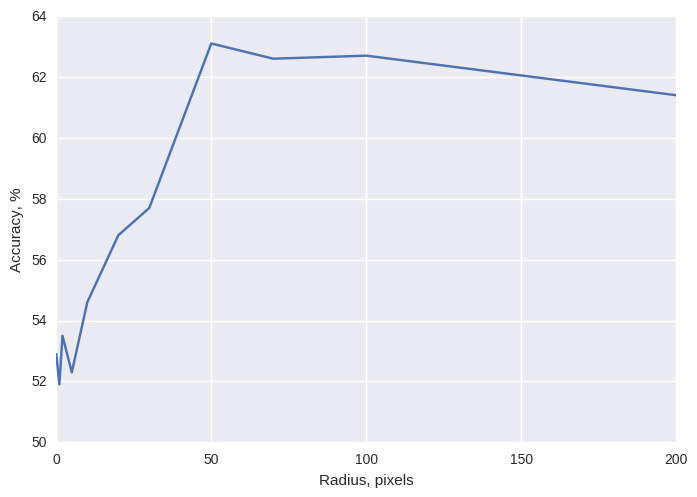

In [11]:
x = [0, 1, 2, 5, 10, 20, 30, 50, 70, 100, 200]
y = [52.9, 51.9, 53.5, 52.3, 54.6, 56.8, 57.7, 63.1, 62.6, 62.7, 61.4]
import seaborn as sbn
plt.ylabel('Accuracy, %')
plt.xlabel('Radius, pixels')
plt.plot(x, y)

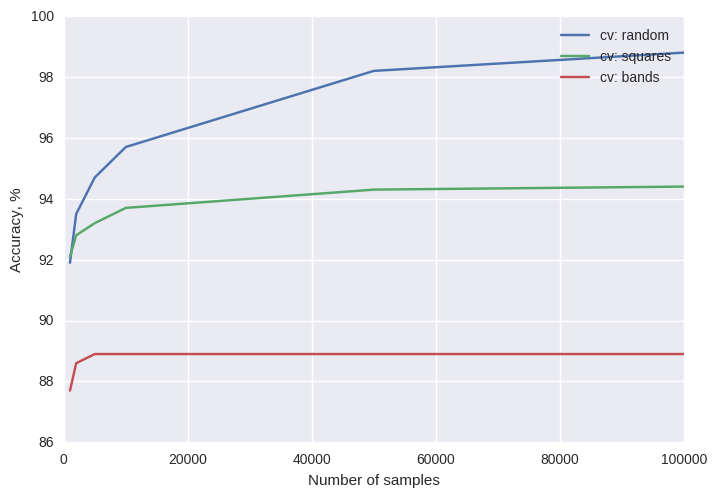

In [20]:
x = [1000, 2000, 5000, 10000, 50000, 100000]
y1 = [91.9, 93.5, 94.7, 95.7, 98.2, 98.8]
y2 = [92.1, 92.8, 93.2, 93.7, 94.3, 94.4]
y3 = [87.7, 88.6, 88.9, 88.9, 88.9, 88.9]
plt.ylabel('Accuracy, %')
plt.xlabel('Number of samples')
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.legend(['cv: random', 'cv: squares', 'cv: bands'])

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


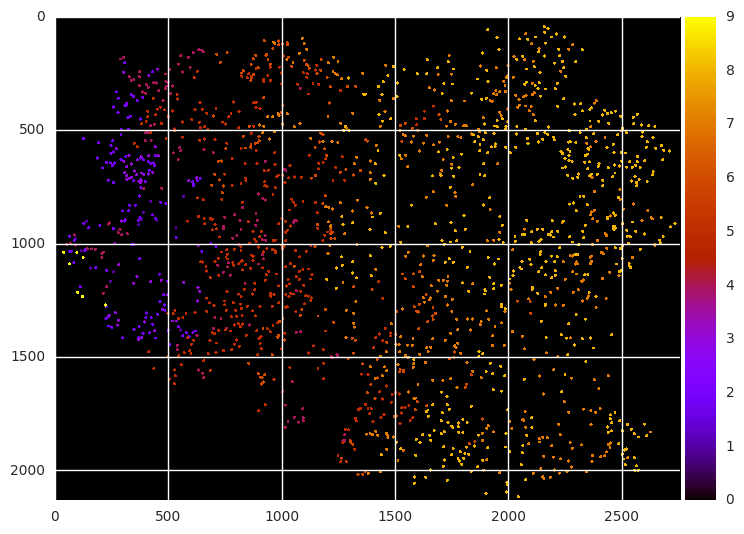

In [35]:
img = A.load_soil_cuts()
skimage.io.imshow(skimage.filters.rank.median(img, skimage.morphology.disk(7), mask=(img > 0)), cmap='gnuplot')

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


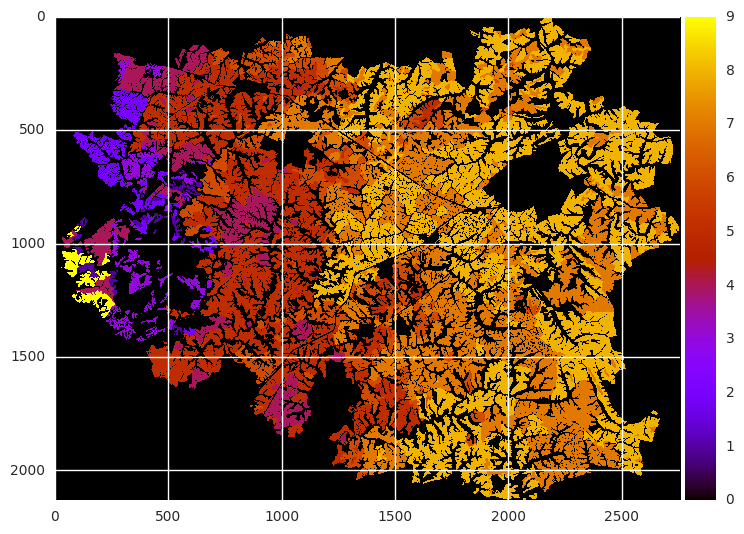

In [32]:
img = A.load_soil_map()
skimage.io.imshow(img, cmap='gnuplot')

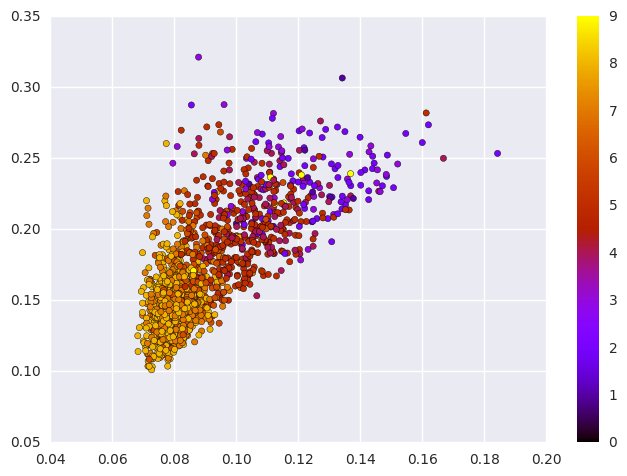

In [34]:
import seaborn as sbn
plt.scatter(C.x_train[:, 0], C.x_train[:, 4], c=C.y_train, cmap='gnuplot', vmin=0)
plt.colorbar()

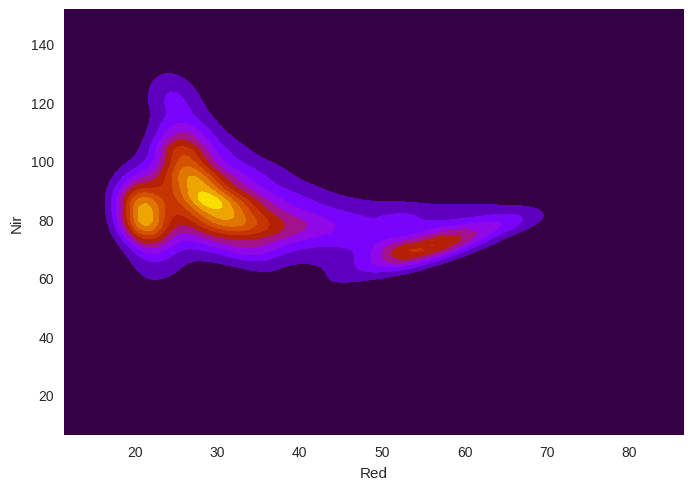

In [17]:
A = Scene('3.json')
index = 13
red = A.read_image(index, 'red', 'original')
nir = A.read_image(index, 'nir', 'original')
import seaborn as sbn
from matplotlib.patches import Ellipse
plt.xlabel('Red')
plt.ylabel('Nir')
sbn.kdeplot(red[:300, :300].ravel(), nir[:300, :300].ravel(),
           shade=True, cmap='gnuplot')

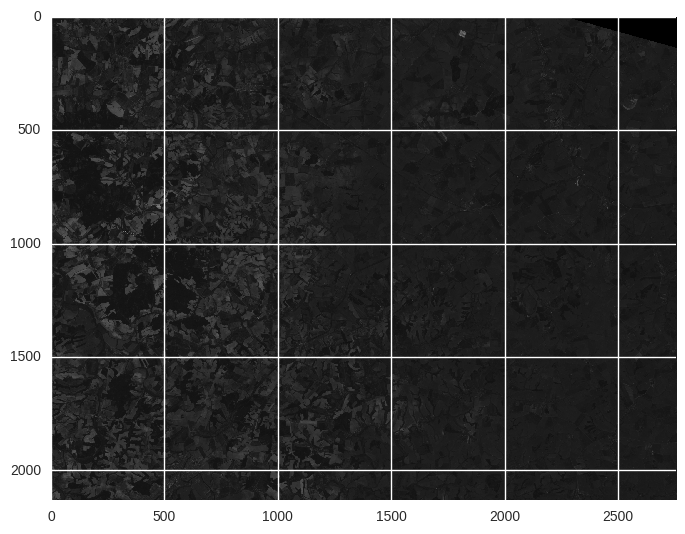

In [12]:
import seaborn as sbn
skimage.io.imshow(A.read_image(13, 'red', 'original'))

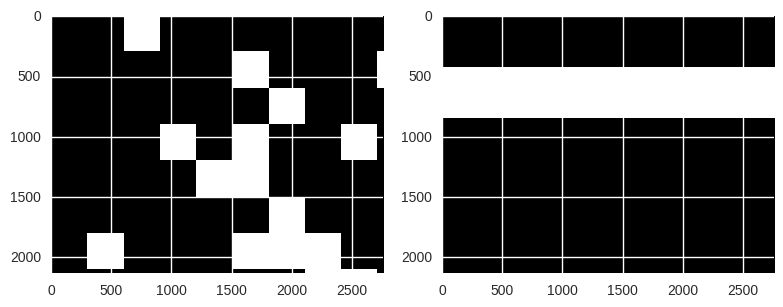

In [29]:
with open('3.json') as f:
    config = simplejson.load(f)
plt.subplot('121')
config['classifier']['train_mask']['mode'] = 'squares'
C = Classifier(features, A.load_soil_map(), config)
skimage.io.imshow(C.train_mask, cmap='gray')
plt.subplot('122')
config['classifier']['train_mask']['mode'] = 'horizontal'
C = Classifier(features, A.load_soil_map(), config)
skimage.io.imshow(C.train_mask, cmap='gray')

In [ ]:
import os
path = '/home/fila/Downloads/Tula_landsat_band_all/'
path_out = '/home/fila/Desktop/landsat2/original/'
filenames = os.listdir(path)

info = {
    'red': [3, 4],
    'nir': [4, 5],
    'blue': [1, 2],
    'green': [2, 3]
}

use_ch = ['red', 'nir', 'blue', 'green']

for ch in use_ch:
    print(ch)
    for f in filenames:
        if (f[2] != '8' and f.split('_')[1].lower() == 'b' + str(info[ch][0]))\
            or (f[2] == '8' and f.split('_')[1].lower() == 'b' + str(info[ch][1])):
            f_lower = f.split('_')[0].lower()
            print(f_lower)
            img = skimage.io.imread(path + f)
            skimage.io.imsave(path_out + ch + '/' + f_lower + '.tif', img[26:-23, 73:-54])

In [14]:
df_old = pd.read_csv('/home/fila/Desktop/landsat2/docs/rad_refl.csv')
df_part = pd.read_csv('/home/fila/Downloads/rad_refl_blue_green.csv')
df_old['rad_blue'] = - df_part['add_blue'] / df_part['mult_blue']
df_old['refl_blue'] = 1 / df_part['mult_blue']
df_old['rad_green'] = - df_part['add_green'] / df_part['mult_green']
df_old['refl_green'] = 1 / df_part['mult_green']
df_old.to_csv('/home/fila/Desktop/landsat2/docs/rad_refl.csv', index=False)